In [24]:
from utils.util import read_dataset

train_data = read_dataset(dirpath="./datasets/it-trajs_complete/train", interpolate=True, normalize=False)

In [25]:
all_label_zeros = []
all_label_ones = []
all_label_twos = []
all_label_threes = []


for filename, dic in train_data.items():
    if filename[0] == '0':
        all_label_zeros.append(dic)
    if filename[0] == '1':
        all_label_ones.append(dic)
    if filename[0] == '2':
        all_label_twos.append(dic)
    if filename[0] == '3':
        all_label_threes.append(dic)


<Axes: xlabel='x'>

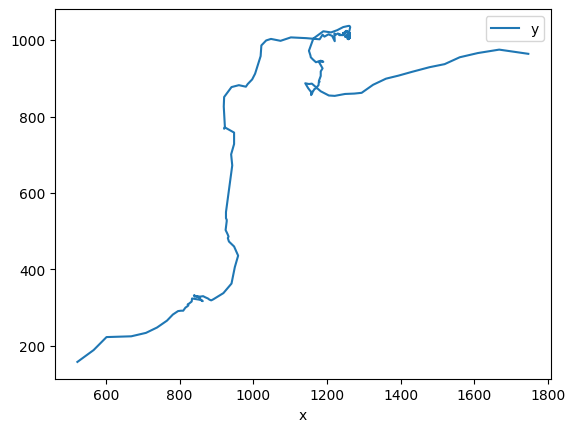

In [26]:
all_label_ones[0]
all_label_ones[0]['dataframe'].plot(x='x', y='y')


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

def extract_feats(df):
    """
    Extract (step-length, cos(turn-angle), sin(turn-angle)) features
    from a trajectory DataFrame with columns ['x','y'].
    """
    coords = df[['x','y']].values
    if len(coords) < 2:
        return np.empty((0, 3))
    deltas = np.diff(coords, axis=0)
    # step lengths
    r = np.linalg.norm(deltas, axis=1)
    # headings
    phi = np.arctan2(deltas[:,1], deltas[:,0])
    # turning angles
    theta = np.diff(phi, prepend=phi[0])
    # return r, cos(theta), sin(theta)
    return np.column_stack([r, np.cos(theta), np.sin(theta)])

def train_hmm(all_label_ones, n_components=3, cov_type='full', n_iter=100):
    """
    Train a Gaussian HMM on the minority-class trajectories,
    using (r, cosθ, sinθ) features.
    
    Parameters:
      all_label_ones: list of dicts with key 'dataframe' (pd.DataFrame with 'x','y')
      n_components: number of hidden states
      cov_type: covariance type for Gaussian emissions
      n_iter: max iterations for fitting
    """
    sequences, lengths = [], []
    for entry in all_label_ones:
        feats = extract_feats(entry['dataframe'])
        if len(feats) > 0:
            sequences.append(feats)
            lengths.append(len(feats))
    X = np.vstack(sequences)
    model = GaussianHMM(n_components=n_components,
                        covariance_type=cov_type,
                        n_iter=n_iter,
                        random_state=42)
    model.fit(X, lengths)
    return model

def generate_synthetic_trajectories(model, all_label_ones, n_samples=50):
    """
    Sample synthetic trajectories from the trained HMM.
    
    Each sample:
      - picks a random length from the real data
      - samples that many steps in (r,cosθ,sinθ) space
      - reconstructs Δx,Δy from (r,θ), accumulates to positions
      - uses a random real start point and random initial heading
    """
    synthetic = []
    # list of original trajectory lengths (in frames)
    orig_lengths = [len(e['dataframe']) for e in all_label_ones if len(e['dataframe']) > 1]
    
    for _ in range(n_samples):
        # pick a real length, convert to number of steps
        L = np.random.choice(orig_lengths)
        n_steps = max(L - 1, 1)
        
        # sample features: (r, cosθ, sinθ)
        feats, _ = model.sample(n_steps)
        r_s, cos_s, sin_s = feats.T
        θ_s = np.arctan2(sin_s, cos_s)
        
        # reconstruct Δx, Δy
        phi0 = np.random.uniform(-np.pi, np.pi)
        cum_phi = phi0 + np.cumsum(θ_s)
        deltas = np.column_stack([r_s * np.cos(cum_phi),
                                  r_s * np.sin(cum_phi)])
        
        # pick a random real starting point
        start_df = np.random.choice(all_label_ones)['dataframe']
        start_pt = start_df[['x','y']].iloc[0].values
        
        # accumulate to get absolute positions
        coords = np.vstack([start_pt, start_pt + np.cumsum(deltas, axis=0)])
        
        # build synthetic DataFrame
        frames = np.arange(len(coords))
        df_syn = pd.DataFrame({
            'frame': frames,
            'x': coords[:,0],
            'y': coords[:,1]
        })
        synthetic.append(df_syn)
    
    return synthetic

def save_trajectories_to_dir(trajectories, output_dir, prefix='traj'):
    """
    Save each trajectory DataFrame to CSV, renaming columns to
      'nframe', 'x0', 'y0' for downstream compatibility.
    """
    os.makedirs(output_dir, exist_ok=True)
    for idx, df in enumerate(trajectories, start=1):
        df_to_save = df.rename(columns={
            'frame': 'nframe',
            'x': 'x0',
            'y': 'y0'
        })
        path = os.path.join(output_dir, f"{prefix}_{idx}.csv")
        df_to_save.to_csv(path, index=False)

def plot_real_vs_synthetic(real_df, synthetic_df):
    """
    Plot one real trajectory (in red) and one synthetic (in blue).
    """
    plt.plot(real_df['x'], real_df['y'], 'r-', label='Real')
    plt.plot(synthetic_df['x'], synthetic_df['y'], 'b-', label='Synthetic')
    plt.xlabel('x'); plt.ylabel('y')
    plt.legend()
    plt.show()



In [28]:

model_one = train_hmm(all_label_ones, n_components=3)
model_two = train_hmm(all_label_twos, n_components=3)
model_three = train_hmm(all_label_threes, n_components=3)


Model is not converging.  Current: 90.54957972093257 is not greater than 218.6804117498109. Delta is -128.13083202887833
Model is not converging.  Current: -17086.668805446086 is not greater than -17085.813794213907. Delta is -0.8550112321790948
Model is not converging.  Current: -23199.95642479643 is not greater than -16452.472157688066. Delta is -6747.484267108364


In [29]:
len_zero = len(all_label_zeros)
len_one = len(all_label_ones)
len_two = len(all_label_twos)
len_three = len(all_label_threes)

In [30]:
synthetic_trajs_one = generate_synthetic_trajectories(model_one, all_label_ones, n_samples=(len_three-len_one))
synthetic_trajs_two = generate_synthetic_trajectories(model_two, all_label_twos, n_samples=(len_three-len_two))
#synthetic_trajs_three = generate_synthetic_trajectories(model_three, all_label_threes, n_samples=((len_zero-len_three)))

In [31]:
import os

def save_trajectories_to_dir(trajectories, output_dir, prefix):
    """
    Save a list of DataFrame trajectories to CSV files in the given directory.
    
    Parameters:
    -----------
    trajectories : list of pd.DataFrame
        Each DataFrame should have columns like ['frame', 'x', 'y'] (or similar).
    output_dir : str
        Path to directory where CSVs will be saved. Will be created if it doesn't exist.
    prefix : str, optional
        Filename prefix for each trajectory. Defaults to 'traj'.
        
    Returns:
    --------
    None
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for idx, df in enumerate(trajectories, start=1):
        df_to_save = df.rename(columns={
            'x': 'x0',
            'y': 'y0',
            'frame': 'nframe'
        })
        filename = f"{prefix}_syn_{idx}.csv"
        path = os.path.join(output_dir, filename)
        df_to_save.to_csv(path, index=False)

In [32]:
synthetic_trajs_two

[     frame            x           y
 0        0   981.000000  740.000000
 1        1   955.561897  695.180558
 2        2   955.406360  699.683393
 3        3   953.863682  699.026144
 4        4   953.629294  698.849590
 ..     ...          ...         ...
 304    304  1073.987709  721.676816
 305    305  1074.031654  721.610834
 306    306  1073.801853  722.366228
 307    307  1072.117820  723.369240
 308    308  1073.567897  724.094551
 
 [309 rows x 3 columns],
     frame            x           y
 0       0  1147.000000  570.000000
 1       1  1125.252465  523.278226
 2       2  1124.734950  527.753926
 3       3  1123.250188  526.974623
 4       4  1123.030773  526.779774
 5       5  1121.356960  525.953518
 6       6  1120.874065  525.613371
 7       7  1122.394404  526.134610
 8       8  1122.966419  524.545311
 9       9  1123.054605  524.297955
 10     10  1122.998738  524.454565
 11     11  1122.200081  524.770410
 12     12  1120.427662  522.889423
 13     13  1122.356388  

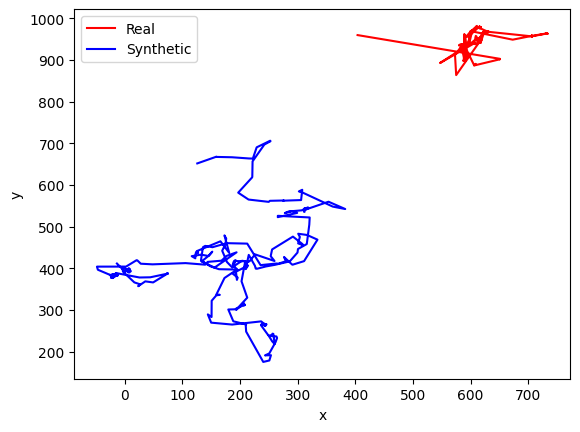

In [37]:
plot_real_vs_synthetic(all_label_twos[0]['dataframe'], synthetic_trajs_one[5])

In [34]:
save_trajectories_to_dir(synthetic_trajs_one, "datasets/it-trajs_synthetic_adv_350/train", "1")
save_trajectories_to_dir(synthetic_trajs_two, "datasets/it-trajs_synthetic_adv_350/train", "2")
#save_trajectories_to_dir(synthetic_trajs_three, "datasets/it-trajs_synthetic/train", "3")
